In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
%matplotlib inline
import numpy as np
import os, shutil, glob, sys, math, cv2, re

import albumentations as albu
import pandas as pd
import seaborn as sns

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict
# from torch.utils import load_state_dict_from_url
from torch.utils.model_zoo import load_url as load_state_dict_from_url
from torch import Tensor
from torch.jit.annotations import List
from torchsummary import summary
from torchvision import models

from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

# model

In [8]:
from utils.VGG import *

In [9]:
class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

In [10]:
# 2D model
class attentionPart(nn.Module):
    def __init__(self, d_model = 512):
        super().__init__()
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=8)

        self.attention_layer = nn.Sequential(
            nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=6),
            nn.AdaptiveMaxPool1d(1),
            Flatten(),
        )
       
    def forward(self, x):       
        attention = self.attention_layer(x)
        return attention

In [11]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [12]:
# 2D model
class classifier(nn.Module):
    def __init__(self, max_images = 200, d_model = 512, dropout=0.1, nclass=10):
        super().__init__()
        self.tumor_grade = 2
        self.max_images = max_images
        self.nclass = nclass
        self.CNN = vgg16_bn(pretrained = True)
#         self.CNN.load_state_dict(torch.load("./weight/vgg16_loss:CE_bs:25epoch:3_fscore:0.9987.h5"), strict = False)
     
        self.pos_encoder = PositionalEncoding(d_model=d_model, dropout=dropout, max_len=max_images)
        self.attention_layer = attentionPart(d_model)
        
        self.classify = nn.Sequential(
            nn.Linear(self.max_images + self.tumor_grade, 32),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(32, nclass)
        )
        # softmax
    def forward(self, x, y):
        batch_size, timesteps, C, H, W = x.size()
        c_in = x.view(batch_size * timesteps, C, H, W)
        c_out = self.CNN(c_in)
        r_in = c_out.view(batch_size, timesteps, -1)
#         print(r_in.shape)
        r_in = self.pos_encoder(r_in)
#         print(r_in.shape)
        attention = self.attention_layer(r_in)
#         print(attention.shape)
        attention = torch.cat((attention, y), 1)
        cls = self.classify(attention)
        return cls

In [13]:
# model = classifier(max_images = 200, d_model = 512, dropout=0.1)
# src = torch.randn(2, 200, 3, 128, 128)
# side_info = torch.randn(2, 2)
# out = model(src, side_info)
# out = out.detach().cpu().numpy()
# print(out.shape)

### data processing

In [14]:
def continuous2discrete(train, test):
    train = np.log(train)
    test = np.log(test)
    train = train.astype('uint8')
    test = test.astype('uint8')
    for i in range(10):
        a = np.count_nonzero(train==i)
        b = np.count_nonzero(test==i)
        print(i, a/len(train), b/len(test))
# continuous2discrete(train_counts, test_counts)

# train test dataset

In [15]:
from utils import normalizeStaining

In [ ]:
def norm(cohort_lists):
    for which, cohort in enumerate(cohort_lists):
        dest_name = './data/rgb_norm_npy/{}.npy'.format(cohort)
        if os.path.exists(dest_name):
            continue
        images = np.load('./data/npy_folder/{}.npy'.format(cohort))
        normed_images = np.zeros_like(images)
        
        for idx, image in enumerate(images):
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            try:
                normed_image = normalizeStaining.normalizeStaining(image)
            except:
                print(cohort, idx, 'error')
                normed_image = image
            normed_images[idx] = normed_image
        np.save(dest_name, normed_images)
norm(non_empty_cohorts)

/home/tsung1271232/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/tsung1271232/.local/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/tsung1271232/pathology/utils/normalizeStaining.py:46: RuntimeWarning: Degrees of freedom <= 0 for slice
  eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))
/home/tsung1271232/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/tsung1271232/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


TCGA-AA-3977 117 error
TCGA-AA-3977 118 error
TCGA-AA-3977 119 error
TCGA-AA-3977 135 error
TCGA-AA-3977 136 error
TCGA-AA-3977 137 error


/home/tsung1271232/pathology/utils/normalizeStaining.py:81: RuntimeWarning: overflow encountered in exp
  Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))


TCGA-AA-3977 153 error
TCGA-AA-3977 154 error
TCGA-AA-3977 160 error
TCGA-AA-3977 161 error
TCGA-F4-6459 106 error
TCGA-F4-6459 109 error
TCGA-F4-6459 141 error
TCGA-F4-6459 142 error
TCGA-F4-6459 143 error
TCGA-F4-6459 145 error
TCGA-F4-6459 148 error
TCGA-F4-6459 149 error
TCGA-F4-6459 156 error
TCGA-F4-6459 157 error
TCGA-F4-6459 158 error
TCGA-F4-6459 159 error
TCGA-F4-6459 160 error
TCGA-F4-6459 185 error


/home/tsung1271232/pathology/utils/normalizeStaining.py:81: RuntimeWarning: overflow encountered in multiply
  Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))


TCGA-F4-6460 2 error
TCGA-F4-6460 10 error
TCGA-F4-6460 105 error
TCGA-F4-6460 106 error
TCGA-F4-6460 119 error
TCGA-F4-6460 126 error
TCGA-F4-6460 127 error
TCGA-F4-6460 129 error
TCGA-F4-6460 136 error
TCGA-F4-6460 137 error
TCGA-F4-6460 138 error
TCGA-F4-6460 139 error
TCGA-F4-6460 142 error
TCGA-F4-6460 143 error
TCGA-F4-6460 144 error
TCGA-F4-6460 145 error
TCGA-F4-6460 148 error
TCGA-F4-6460 150 error
TCGA-F4-6460 151 error
TCGA-F4-6460 152 error
TCGA-F4-6460 153 error
TCGA-F4-6460 154 error
TCGA-F4-6460 160 error
TCGA-F4-6460 166 error
TCGA-F4-6460 167 error
TCGA-F4-6460 168 error
TCGA-F4-6460 169 error
TCGA-F4-6460 170 error
TCGA-F4-6460 171 error
TCGA-F4-6460 178 error
TCGA-F4-6460 183 error
TCGA-F4-6460 185 error
TCGA-F4-6460 186 error
TCGA-F4-6460 187 error
TCGA-F4-6460 188 error
TCGA-F4-6460 189 error
TCGA-F4-6460 195 error
TCGA-F4-6460 196 error


In [ ]:
train_cohorts, test_cohorts, train_counts, test_counts, train_grade, test_grade = train_test_split(
    non_empty_cohorts, non_empty_counts, non_empty_grade, test_size=0.2, random_state=42)
print(len(train_cohorts), len(train_counts), len(train_grade))
print(len(test_cohorts), len(test_counts), len(test_grade))

In [ ]:
class Dataset(BaseDataset):
    
    def __init__(self, cohort_array, label_array, tumor_grade_array, image_size = None, augmentation=None, preprocessing=None):
        self.cohort_array = cohort_array
        self.label_array = label_array
        self.tumor_grade_array = tumor_grade_array
        self.image_size = image_size
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        fp = self.cohort_array[i]
        images = np.load('./data/rgb_norm_npy/{}.npy'.format(fp))
        
        if self.image_size is not None:
            resized_images = np.zeros((images.shape[0], self.image_size, self.image_size, images.shape[3]))
            for idx, image in enumerate(images):
                temp_image = cv2.resize(image, (self.image_size, self.image_size))
                resized_images[idx] = temp_image
            del images
            images = resized_images.transpose(0, 3, 1, 2).astype('float32')
        else:
            images = images.transpose(0, 3, 1, 2).astype('float32')
            
        label = self.label_array[i]
        label = label.astype('float32')
        label = np.log(label)
        label = label.astype('int64')

        tumor_grade = self.tumor_grade_array[i]
        if tumor_grade == 1.0:
            tumor_grade = np.array([1, 0])
        elif tumor_grade == 2.0:
            tumor_grade = np.array([0, 1])
            
        return images, tumor_grade, label
        
    def __len__(self):
        return len(self.cohort_array)

# loss

In [ ]:
class MSELoss(nn.Module):
    def __init__(self):
        super().__init__()
    @property
    def __name__(self):
        return 'mseloss'
    def forward(self, pred, gt):
        pred = torch.squeeze(pred)
        output = nn.MSELoss()(pred, gt)
        return output
    
class L1Loss_exp(nn.Module):
    def __init__(self):
        super().__init__()
    @property
    def __name__(self):
        return 'l1loss_exp'
    def forward(self, pred, gt):
        pred = torch.squeeze(pred)
        pred = torch.exp(pred)
        gt = torch.exp(gt)
        output = nn.L1Loss()(pred, gt)
        return output
    
class L1Loss(nn.Module):
    def __init__(self):
        super().__init__()
    @property
    def __name__(self):
        return 'l1loss'
    def forward(self, pred, gt):
        pred = torch.squeeze(pred)
        output = nn.L1Loss()(pred, gt)
        return output

        
class CrossEntropy(nn.Module):
    def __init__(self, weight = None):
        super().__init__()
        self.weight = weight
    @property
    def __name__(self):
        return 'cross entropy'
    def forward(self, y_pred, y_gt):
        if self.weight is None:
            return nn.CrossEntropyLoss()(y_pred, y_gt)
        else:
            self.weight = torch.tensor(self.weight).cuda()
            return nn.CrossEntropyLoss(weight=self.weight)(y_pred, y_gt)

class Accuracy(nn.Module):
    def __init__(self):
        super().__init__()
    @property
    def __name__(self):
        return 'accuracy'
    def forward(self, y_pred, y_gt):
        y_pred = torch.softmax(y_pred, dim = 1)
        y_pred = torch.argmax(y_pred, axis = 1)
        tp = torch.sum(y_gt == y_pred, dtype=y_pred.dtype)
        tp = tp.type(torch.DoubleTensor)
        score = tp/y_gt.view(-1).shape[0]
#         print(y_pred, y_gt)
#         score = torch.true_divide(tp, y_gt.view(-1).shape[0])
        return score

# model settings

In [ ]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 10 epochs"""
    lr = 1e-3 * (0.1 ** (epoch // 10))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
def make_weights_for_balanced_classes(_y):
    nclasses = len(np.unique(_y))
    weight_per_class = {i: 0. for i in range(10)}
    count_per_class = {i: 0. for i in np.unique(_y)}
    for i in _y:
        count_per_class[i] += 1    
    for i in np.unique(_y):
        weight_per_class[i] = len(_y)/float(count_per_class[i])
    weights = [0.] * len(_y)
    for idx, val in enumerate(_y):
        weights[idx] = weight_per_class[val]
    return weights, weight_per_class

In [ ]:
weights, weight_per_class = make_weights_for_balanced_classes(np.log(train_counts).astype('uint8'))
weights = torch.DoubleTensor(weights)
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights=weights, num_samples=len(weights), replacement=True)

_temp = 0
for key, value in weight_per_class.items():
    _temp += value

weight_per_class = [weight_per_class[i]/_temp for i in range(10)]

In [ ]:
batch_size = 1
nclass = 10
epoch = 50
model_arch = 'vgg16_bn'
train_loss = 'ce'
train_metric = 'accu'
use_sampler = True
init_lr = 1e-4
image_size = 128

In [ ]:
model = classifier(max_images = 200, d_model = 512, dropout=0.1, nclass=nclass)

In [ ]:
train_dataset = Dataset(
    train_cohorts,
    train_counts,
    train_grade,
    image_size = image_size
)

valid_dataset = Dataset(
    test_cohorts,
    test_counts,
    test_grade,
    image_size = image_size
)

if use_sampler:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                          sampler=sampler, num_workers=batch_size)
else:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                              shuffle=True, num_workers=batch_size)
    
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, 
                          shuffle=False, num_workers=batch_size)

In [ ]:
loss = CrossEntropy(weight=None)

metrics = [
    Accuracy()
]


optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=init_lr),
])

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer = optimizer, T_max=epoch, eta_min=1e-7)


# train

In [ ]:
import sys
import torch
from tqdm import tqdm as tqdm

class Epoch:

    def __init__(self, model, loss, metrics, stage_name, device='cpu', verbose=True):
        self.model = model
        self.loss = loss
        self.metrics = metrics
        self.stage_name = stage_name
        self.verbose = verbose
        self.device = device

        self._to_device()

    def _to_device(self):
        self.model.to(self.device)
        self.loss.to(self.device)
        for metric in self.metrics:
            metric.to(self.device)

    def _format_logs(self, logs):
        str_logs = ['{} - {:.4}'.format(k, v) for k, v in logs.items()]
        s = ', '.join(str_logs)
        return s

    def batch_update(self, x, x2, y):
        raise NotImplementedError

    def on_epoch_start(self):
        pass

    def run(self, dataloader):

        self.on_epoch_start()

        logs = {}
        loss_meter = smp.utils.meter.AverageValueMeter()
        metrics_meters = {metric.__name__: smp.utils.meter.AverageValueMeter() for metric in self.metrics}

        with tqdm(dataloader, desc=self.stage_name, file=sys.stdout, disable=not (self.verbose)) as iterator:
            for x, x2, y in iterator:
                x, x2, y = x.to(self.device), x2.to(self.device), y.to(self.device)
                loss, y_pred = self.batch_update(x, x2, y)

                # update loss logs
                loss_value = loss.cpu().detach().numpy()
                loss_meter.add(loss_value)
                loss_logs = {self.loss.__name__: loss_meter.mean}
                logs.update(loss_logs)

                # update metrics logs
                for metric_fn in self.metrics:
                    metric_value = metric_fn(y_pred, y).cpu().detach().numpy()
                    metrics_meters[metric_fn.__name__].add(metric_value)
                metrics_logs = {k: v.mean for k, v in metrics_meters.items()}
                logs.update(metrics_logs)

                if self.verbose:
                    s = self._format_logs(logs)
                    iterator.set_postfix_str(s)

        return logs


class TrainEpoch(Epoch):

    def __init__(self, model, loss, metrics, optimizer, device='cpu', verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name='train',
            device=device,
            verbose=verbose,
        )
        self.optimizer = optimizer

    def on_epoch_start(self):
        self.model.train()

    def batch_update(self, x, x2, y):
        self.optimizer.zero_grad()
        prediction = self.model.forward(x, x2)
        loss = self.loss(prediction, y)
        loss.backward()
        self.optimizer.step()
        return loss, prediction


class ValidEpoch(Epoch):

    def __init__(self, model, loss, metrics, device='cpu', verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name='valid',
            device=device,
            verbose=verbose,
        )

    def on_epoch_start(self):
        self.model.eval()

    def batch_update(self, x, x2, y):
        with torch.no_grad():
            prediction = self.model.forward(x, x2)
            loss = self.loss(prediction, y)
        return loss, prediction

In [ ]:
use_cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda:0" if use_cuda else "cpu")

train_epoch = TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
import time
current_time = time.strftime("%Y_%m_%d_%H_%M", time.localtime())


model_name = './weight/' + "{}_MCnt-CN-log_sampler{}_loss:{}_bs:{}".format(
    current_time, use_sampler*1, train_loss, batch_size)

cur_metric = 0

train_history = []
valid_history = []
for i in range(0, epoch):
    # adjust_learning_rate(optimizer, i)
    print('\nEpoch: {}, batch: {}'.format(i, batch_size))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    train_history.append(train_logs)
    valid_history.append(valid_logs)
    lr_scheduler.step()
    
    if cur_metric < valid_logs[metrics[0].__name__]:
        cur_metric = valid_logs[metrics[0].__name__]
        torch.save(model.state_dict(), model_name+"_epoch{}_{}:{:.4f}".format(i,train_metric, cur_metric)+".h5")
        print('Model saved!', model_name+"_epoch{}_{}:{:.4f}".format(i,train_metric, cur_metric)+".h5")

    for param_group in optimizer.param_groups:
        print(param_group['lr'])
#     if cur_metric > valid_logs[metrics[0].__name__]:
#         cur_metric = valid_logs[metrics[0].__name__]
#         torch.save(model.state_dict(), model_name+"_epoch{}_{}:{:.4f}".format(i,train_metric, cur_metric)+".h5")
#         print('Model saved!', model_name+"_epoch{}_{}:{:.4f}".format(i,train_metric, cur_metric)+".h5")

In [36]:
print(model_name+"test.h5")

./weight/2020_09_09_16_07_mCount-reg-log-end2end_sampler_loss:model_arch_bs:cetest.h5


In [37]:
def plt_history(history):
    loss1 = []
    metric1 = []
    metric2 = []
    for i in history:
        loss1.append(i['cross entropy'])
        metric1.append(i['accuracy'])
    plt.figure()
    p1 = plt.plot(loss1, label='cross entropy')
    p2 = plt.plot(metric1, label='accuracy')
    plt.legend()

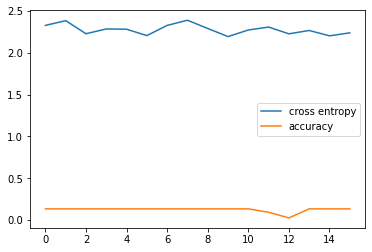

In [38]:
plt_history(valid_history)

# valid

In [19]:
train_dataset = Dataset(
    train_cohorts,
    train_counts,
#     augmentation=get_training_augmentation(),
#     preprocessing=get_preprocessing(),
)

valid_dataset = Dataset(
    test_cohorts,
    test_counts,
#     augmentation=get_validation_augmentation(),
#     preprocessing=get_preprocessing(),
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                          shuffle=True, num_workers=batch_size)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, 
                          shuffle=False, num_workers=batch_size)

In [31]:
model = classifier(max_images = 200, d_model = 512, dropout=0.1)
model.load_state_dict(torch.load('./weight/2020_09_09_16_07_mCount-reg-log-end2end_sampler_loss:model_arch_bs:cetest.h5'))
model = model.cuda()

In [43]:
gt_list = []
pred_list = []
_temp = 0
metric = Accuracy()
for data in train_loader:
    images, x2, labels = data
    images = images.cuda()
    x2 = x2.cuda()
    labels = labels.cuda()
    with torch.no_grad():
        pred = model.forward(images, x2)
    pred = torch.softmax(pred, axis = 1)
    pred = torch.argmax(pred, axis = 1)
    pred = pred.detach().cpu().numpy()
    pred = pred.squeeze()
    pred_list.extend(pred)

    labels = labels.detach().cpu().numpy()
    gt_list.extend(labels)
gt_list = np.array(gt_list)
pred_list = np.array(pred_list)

In [44]:
import seaborn as sns

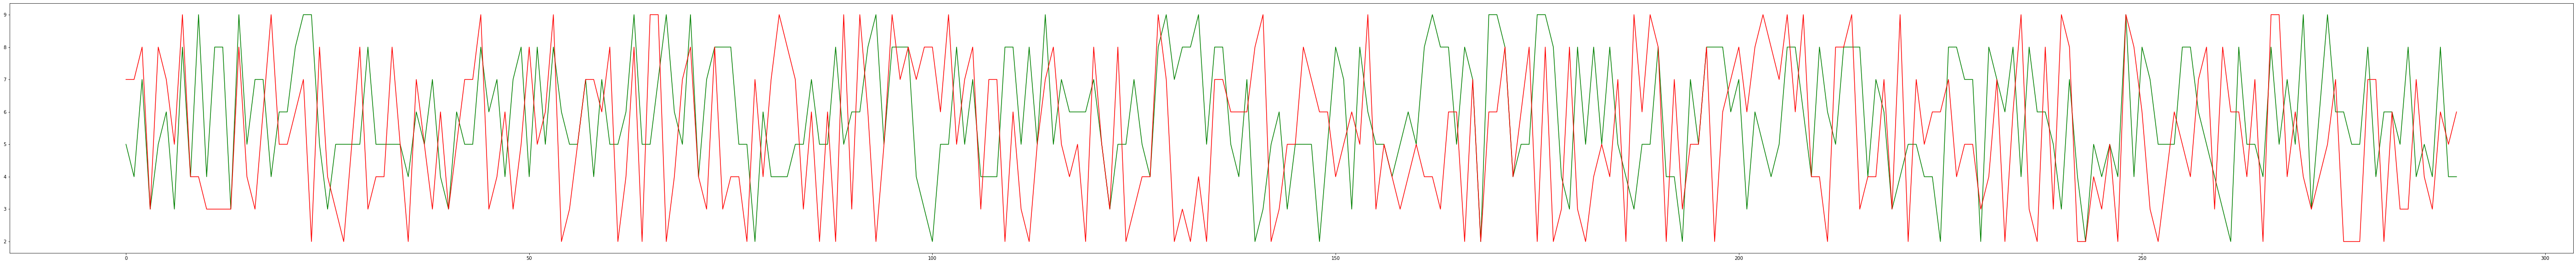

In [45]:
plt.figure(figsize=(100,10))
plt.plot(pred_list, color="g")
plt.plot(gt_list, color="r")

In [46]:
for gt, pred in zip(gt_list, pred_list):
    print("{:.4f}, {:.4f}, {:.4f}".format(gt, pred, np.abs(gt-pred)))

7.0000, 5.0000, 2.0000
7.0000, 4.0000, 3.0000
8.0000, 7.0000, 1.0000
3.0000, 3.0000, 0.0000
8.0000, 5.0000, 3.0000
7.0000, 6.0000, 1.0000
5.0000, 3.0000, 2.0000
9.0000, 8.0000, 1.0000
4.0000, 4.0000, 0.0000
4.0000, 9.0000, 5.0000
3.0000, 4.0000, 1.0000
3.0000, 8.0000, 5.0000
3.0000, 8.0000, 5.0000
3.0000, 3.0000, 0.0000
8.0000, 9.0000, 1.0000
4.0000, 5.0000, 1.0000
3.0000, 7.0000, 4.0000
6.0000, 7.0000, 1.0000
9.0000, 4.0000, 5.0000
5.0000, 6.0000, 1.0000
5.0000, 6.0000, 1.0000
6.0000, 8.0000, 2.0000
7.0000, 9.0000, 2.0000
2.0000, 9.0000, 7.0000
8.0000, 5.0000, 3.0000
4.0000, 3.0000, 1.0000
3.0000, 5.0000, 2.0000
2.0000, 5.0000, 3.0000
5.0000, 5.0000, 0.0000
8.0000, 5.0000, 3.0000
3.0000, 8.0000, 5.0000
4.0000, 5.0000, 1.0000
4.0000, 5.0000, 1.0000
8.0000, 5.0000, 3.0000
5.0000, 5.0000, 0.0000
2.0000, 4.0000, 2.0000
7.0000, 6.0000, 1.0000
5.0000, 5.0000, 0.0000
3.0000, 7.0000, 4.0000
6.0000, 4.0000, 2.0000
3.0000, 3.0000, 0.0000
5.0000, 6.0000, 1.0000
7.0000, 5.0000, 2.0000
7.0000, 5.0

In [47]:
np.corrcoef(gt_list, pred_list)

array([[1.        , 0.00321887],
       [0.00321887, 1.        ]])

whole slide

zStats density

transformer pretrain
svs 加入空間關係

consine scheduler   